In [5]:
import numpy as np
from scipy.signal import correlate

P = 1024    # The number of grid points in each dimension
N = P**2       # Total dimensions of Covariance Matrix
sigma = 0.1     # Scaling parameter
A = 0.05       # Normalization factor
Q = int(np.sqrt(P))

n_samples = 1

x = np.linspace(0, 1 - 1/N, P)
y = np.linspace(0, 1 - 1/N, P)

def Covariance_Matrix(x,y):
    def distance(x1,x2,y1,y2):
        distx = np.abs(x1 - x2)
        disty = np.abs(y1 - y2)
        if distx >= 0.5:
                    distx = 1.0 - distx
        if disty >= 0.5:
                    disty = 1.0 - disty
        dist = np.sqrt(distx**2 +disty**2)
        return dist

    Cov_Matrix = np.zeros((P, P))

    for i in range(P):
        for j in range(P):
            Cov_Matrix[i, j] = A * np.exp(-(distance(x[i],x[j],y[i],y[j])**2)/ (2 * sigma**2))
    
    return Cov_Matrix
Cov_Matrix = Covariance_Matrix(x,y)

def Eigenvalue_calculation(Cov_Matrix):
    eigenvalues, V = np.linalg.eig(Cov_Matrix) 
    D = np.diag(eigenvalues)
    V = np.real(V)

    # Remove small eigenvalues
    def diagonal_elements():
        Diagonal_elements = np.array([])
        for i in range(P):
            Diagonal_elements = np.append(Diagonal_elements, D[i, i])
        return Diagonal_elements
    
    def Eig_removal():
        diagonal = diagonal_elements() 
        for k in range(len(diagonal_elements())): 
            if diagonal[k] < 0:
                diagonal[k] = 0
        return diagonal

    Dtest = np.real(np.diag(Eig_removal()))
    F = V @ np.sqrt(Dtest)
    return F
F = Eigenvalue_calculation(Cov_Matrix)

f = np.zeros((P, 2, n_samples))
for i in range(n_samples):
    f[:, :, i] = np.dot(F, np.random.normal(0, 1, size = (P,2)))

V_y = f[:,0,:]/500              
V_x = f[:,1,:]/500

V_x = np.reshape(V_x,(Q,Q,n_samples))
V_y = np.reshape(V_y,(Q,Q,n_samples))

In [6]:
del Cov_Matrix

## Defined Values

In [7]:
tmax = 0.03
dt = 0.01
M = round(tmax/dt)
O = int(M/2)

if P == 4096:
    Number_of_interogation_windows = 32
    N_regions_pixelation = int(P/4)

else:
    Number_of_interogation_windows = 16
    N_regions_pixelation = int(P/4)

N_particles = Number_of_interogation_windows*75

peak_intensity = 250
particle_diameter = 0.01
image_size = P
x_img = np.linspace(0,1,image_size)
y_img = np.linspace(0,1,image_size)
x_grid, y_grid = np.meshgrid(x_img, y_img)
pixelating_grid = int(P/4)


Noise_max = np.random.randint(0,25)
Gradient_max = np.random.randint(0,50)


number_of_pixels_to_move = 10
pixel_to_move = np.arange(-(number_of_pixels_to_move), (number_of_pixels_to_move))

area_to_search_x = np.arange(0, N_regions_pixelation + Number_of_interogation_windows, Number_of_interogation_windows)
area_to_search_y = np.arange(0, N_regions_pixelation +Number_of_interogation_windows, Number_of_interogation_windows)

## Functions

In [28]:
def homogenous_particle_seeding(N_particles):
    Initial_position = np.zeros([N_particles,2])
    particle_in_a_bin = int(N_particles/Number_of_interogation_windows)
    bin_edges = np.linspace(0,1,Number_of_interogation_windows+1)

    for i in range(Number_of_interogation_windows):
            a = np.random.uniform(bin_edges[i],bin_edges[i+1],particle_in_a_bin)
            Initial_position[i * particle_in_a_bin:(i + 1) * particle_in_a_bin] = a

    Initial_position[:,0] = np.random.rand(N_particles)        ###########X component of Initital position
    Initial_position[:,1] = np.random.rand(N_particles)        ###########Y component of Initital position
    return Initial_position

def velocity_field_mean(Vx,Vy):
    vx_step = int(len(Vx)/int(np.sqrt(N_regions_pixelation)))       ##Calculates how many points are there in 1 pixel.
    vx_mean = np.zeros([int(np.sqrt(N_regions_pixelation)),int(np.sqrt(N_regions_pixelation))])

    vy_step = int(len(Vy)/int(np.sqrt(N_regions_pixelation)))       ##Calculates how many points are there in 1 pixel.
    vy_mean = np.zeros([int(np.sqrt(N_regions_pixelation)),int(np.sqrt(N_regions_pixelation))])
    for h in range(0,len(Vy),vy_step):
        for i in range(0,len(Vy),vy_step):
            z = int(i/vx_step)
            q = int(h/vx_step)
            region_x = Vx[h:h+vx_step,i:i+vx_step]
            vx_mean[q,z] = np.mean(region_x)

            region_y = Vy[h:h+vx_step,i:i+vx_step]
            vy_mean[q,z] = np.mean(region_y)
    return vx_mean, vy_mean

def wrap_position(pos):
    return pos%1

def Velocity_Interpolation(current_x_position,current_y_position):
    x_diff_array = np.zeros(P)
    y_diff_array = np.zeros(P)

    x_diff_array = np.abs(x - current_x_position)                           ##Calculates the closest point in the "Continous grid" to the particle.
    y_diff_array = np.abs(y - current_y_position)
                                                                            ## Closest front and back point in X and y seperated
    x_back_point_index = np.argmin(x_diff_array) 
    y_back_point_index = np.argmin(y_diff_array)

    if x[x_back_point_index] > current_x_position:
        x_back_point_index -= 1 

    if y[y_back_point_index] > current_y_position:
        y_back_point_index -= 1 
    
    x_front_point_index = (x_back_point_index + 1) % len(x)
    y_front_point_index = (y_back_point_index + 1) % len(y)
                                                                                        ###Calcualtes distance to the edges of the square mesh grid
    distance_vector = np.zeros([4])
    indices = np.zeros([4,2], dtype = int)

    indices[0,:] = x_back_point_index, y_back_point_index
    indices[1,:] = x_back_point_index, y_front_point_index                   
    indices[2,:] = x_front_point_index, y_back_point_index                   
    indices[3,:] = x_front_point_index, y_front_point_index                   

                                                ##########################Distance_vector = [back_back, back_front, front_back, front_front]
    distance_vector[0] = np.sqrt((current_x_position - x[x_back_point_index])**2 + (current_y_position - y[y_back_point_index])**2)
    distance_vector[1] = np.sqrt((current_x_position - x[x_back_point_index])**2 + (current_y_position - y[y_front_point_index])**2)
    distance_vector[2] = np.sqrt((current_x_position - x[x_front_point_index])**2 + (current_y_position - y[y_back_point_index])**2)
    distance_vector[3] = np.sqrt((current_x_position - x[x_front_point_index])**2 + (current_y_position - y[y_front_point_index])**2)


                                                                                                #### Identifies the 3 closest points in the mesh.
    sorted_distances = np.argsort(distance_vector)
    x1_index, y1_index = indices[sorted_distances[0],0],indices[sorted_distances[0],1]
    x2_index, y2_index = indices[sorted_distances[1],0],indices[sorted_distances[1],1]
    x3_index, y3_index = indices[sorted_distances[2],0],indices[sorted_distances[2],1]

    x1, y1 = x[x1_index], y[y1_index]
    x2, y2 = x[x2_index], y[y2_index]
    x3, y3 = x[x3_index], y[y3_index]

    vx1 = Vx[y1_index//Q,x1_index%Q]
    vx2 = Vx[y2_index//Q,x2_index%Q]
    vx3 = Vx[y3_index//Q,x3_index%Q]

    vy1 = Vy[y1_index//Q,x1_index%Q]
    vy2 = Vy[y2_index//Q,x2_index%Q]
    vy3 = Vy[y3_index//Q,x3_index%Q]

                                                                                                        ##### Ac = b to find the coefficients  x
    C_x = 1 
    A_x = np.array([[x1, y1, C_x], [x2, y2, C_x], [x3, y3, C_x]])
    b_x = np.array([vx1,vx2,vx3])
    
    if np.linalg.det(A_x) == 0:
        print('A', A_x)

    A_x_inverse = np.linalg.inv(A_x)
    c_x = np.dot(A_x_inverse,b_x)
    C_y = 1
    A_y = np.array([[x1, y1, C_y], [x2, y2, C_y], [x3, y3, C_y]])
    b_y = np.array([vy1,vy2,vy3])

    if np.linalg.det(A_y) == 0:
        print('A', A_y)
    A_y_inverse = np.linalg.inv(A_y)
    c_y = np.dot(A_y_inverse,b_y)

                                                                                                                    #### Fits it to a plane Lambda = Ax + By + D
    particle_velocity_x = c_x[0]*current_x_position + c_x[1]*current_y_position + c_x[2]
    particle_velocity_y = c_y[0]*current_x_position + c_y[1]*current_y_position + c_y[2]

    return particle_velocity_x,particle_velocity_y


def Rk4(xi, yi, vxi,vyi, Forward_or_backward):
                                                                                        ######### RK4 STEPPER; look at markdown cell above
    slope_1_x, slope_1_y = vxi, vyi
    
    x_half, y_half  = wrap_position(xi + slope_1_x*dt/2), wrap_position( yi + slope_1_y*dt/2)
    
    slope_2_x,slope_2_y = Velocity_Interpolation(x_half,y_half)
    
    x_quarter, y_quarter = wrap_position(xi + slope_2_x*dt/2), wrap_position(yi + slope_2_y*dt/2)
    
    slope_3_x,  slope_3_y = Velocity_Interpolation(x_quarter,y_quarter)
    
    x_three_quarters,y_three_quarters = wrap_position(xi + slope_3_x*dt),wrap_position( yi + slope_3_y*dt)
    
    slope_4_x, slope_4_y = Velocity_Interpolation(x_three_quarters, y_three_quarters)
    
    if Forward_or_backward == 'Forward':

        next_position_x = xi + ((dt/6)*((slope_1_x)+ (2*slope_2_x)+(2*slope_3_x)+ slope_4_x))
        next_position_y = yi + ((dt/6)*((slope_1_y)+ (2*slope_2_y)+(2*slope_3_y)+ slope_4_y))

    elif Forward_or_backward == 'Backward':
        next_position_x = xi - ((dt/6)*(slope_1_x)+ (2*slope_2_x)+(2*slope_3_x)+ slope_4_x)
        next_position_y = yi - ((dt/6)*(slope_1_y)+ (2*slope_2_y)+(2*slope_3_y)+ slope_4_y)

    next_position_x = wrap_position(next_position_x)
    next_position_y = wrap_position(next_position_y)


    return next_position_x, next_position_y



def space_mean_function():
                                                            ##Assigns the average of space_step points to an index in space mean (same as velcoity)
    space = x
    space_mean = np.zeros([N_regions_pixelation])
    space_step = int(N/N_regions_pixelation)

    for i in range(0,len(x),space_step):
        area = space[i:i+space_step]
        z = int(i/space_step)
        space_mean[z] = np.mean(area)
    return space_mean
space_mean = space_mean_function()

def intensity_vector_function(Two_columns):
    
    intensity_back = np.zeros((N_particles,image_size,image_size))
    intensity_forw = np.zeros((N_particles,image_size,image_size))

    for i in range(N_particles):                                        ##Using the formula in the book to convert positions into internsity profiles
        intensity_back[i,:,:] = peak_intensity*np.exp((-(x_grid-Two_columns[i,0,0])**2-(y_grid - Two_columns[i,0,1])**2)/(particle_diameter**2/8))
        intensity_forw[i,:,:] = peak_intensity*np.exp((-(x_grid-Two_columns[i,1,0])**2-(y_grid - Two_columns[i,1,1])**2)/(particle_diameter**2/8))

                                                                        ## Normalizes the peaks to 250 (some may have been lower due to finite resolution of continous grid P)
        for j in range(0,image_size):
            if np.max(intensity_back[i,j,:]) > 150:
                max_intensity = np.argmax(intensity_back[i,j,:])
                intensity_back[i,j,max_intensity] = 250
                j =- 1
            if np.max(intensity_forw[i,j,:]) > 150:
                max_intensity = np.argmax(intensity_forw[i,j,:])
                intensity_forw[i,j,max_intensity] = 250
                j =- 1

    all_intensities_back = np.zeros([image_size,image_size])
    all_intensities_forw = np.zeros([image_size,image_size])
    for k in range(0,image_size):
        for l in range (0,image_size):  ##Sums up at the intensity values at a specific location in space. The particles are now indistinguishable between images
            all_intensities_back[l,k] = np.sum(intensity_back[:,l,k])
            all_intensities_forw[l,k] = np.sum(intensity_forw[:,l,k])

    return all_intensities_back,all_intensities_forw

def Noise(all_intensities_back,all_intensities_forw):
    Snap_1_Noise = np.random.uniform(0,25, size = [len(all_intensities_back),len(all_intensities_back)])
    Snap_2_Noise = np.random.uniform(0,25, size = [len(all_intensities_forw),len(all_intensities_back)])


    Noise_snap_1 = all_intensities_back + Snap_1_Noise
    Noise_snap_2 = all_intensities_forw + Snap_2_Noise
    return Noise_snap_1,Noise_snap_2 , Snap_1_Noise, Snap_2_Noise


def Gradient(all_intensities_back,all_intensities_forw):
    noise_gradient = Gradient_max*np.abs(x_grid-0.5)
    gradient_rolled_in_x = np.roll(noise_gradient,np.random.randint(-(int(len(all_intensities_back/2))),int(len(all_intensities_back)/2)), axis = 0)
    gradient_rolled_in_y = np.roll(noise_gradient,np.random.randint(-(int(len(all_intensities_back/2))),int(len(all_intensities_back)/2)), axis = 1)

    gradient_snap_1 = all_intensities_back + gradient_rolled_in_x + gradient_rolled_in_y
    gradient_snap_2 = all_intensities_forw+ gradient_rolled_in_x + gradient_rolled_in_y

    return gradient_snap_1, gradient_snap_2, gradient_rolled_in_x, gradient_rolled_in_y



def Noise_and_Gradient(all_intensities_back,all_intensities_forw, Snap_1_Noise, Snap_2_Noise, gradient_rolled_x,gradient_rolled_y):
    Noise_and_gradient_snap_1 = all_intensities_back + Snap_1_Noise + gradient_rolled_x
    Noise_and_gradient_snap_2 = all_intensities_forw + Snap_2_Noise + gradient_rolled_y

    return Noise_and_gradient_snap_1, Noise_and_gradient_snap_2

def pixelating_intensities(all_intensities_back, all_intensities_forw):
    intensity_step = int(len(all_intensities_back[0,:])/pixelating_grid)
    intensity_mean_back = np.zeros([pixelating_grid,pixelating_grid])
    intensity_mean_forw = np.zeros([pixelating_grid,pixelating_grid])
                                                                        ##Same procedure as pixelation of velocity and space.
                                                                        ##Takes intensity_step number of indices then calulacates their avergae and assigns it an index of intensity_mean_forw 
    for h in range(0,image_size,intensity_step):
        for i in range(0,image_size,intensity_step):
            z = int(i/intensity_step)
            q = int(h/intensity_step)
            region_back = all_intensities_back[h:h+intensity_step,i:i+intensity_step]
            intensity_mean_back[q,z] = np.mean(region_back)

            region_forw = all_intensities_forw[h:h+intensity_step,i:i+intensity_step]
            intensity_mean_forw[q,z] = np.mean(region_forw)

    for m in range(0,len(intensity_mean_back[:,0])):
        for k in range(0,len(intensity_mean_forw[0,:])): 
            if intensity_mean_back[m,k] >250:
                intensity_mean_back[m,k] = 250
            if intensity_mean_forw[m,k] >250:
                intensity_mean_forw[m,k] = 250


    return intensity_mean_back, intensity_mean_forw


def bad_correlation_check(correlation_matrix):
    maximum = np.zeros([len(correlation_matrix[:,0])])
    minimum = np.zeros([len(correlation_matrix[:,0])])
    for i in range(len(correlation_matrix[:,0])):
        maximum[i] = np.max(correlation_matrix[i,:])
        minimum[i] = np.min(correlation_matrix[i,:])
    avg_maximum = np.mean(maximum)
    avg_minimum = np.mean(minimum)
    correlation_matrix[correlation_matrix  < int(avg_maximum/4)] = np.nan
    return correlation_matrix


def sub_pixel_interpolation(correlation_map, peak_x, peak_y):
    height, width = correlation_map.shape

    if peak_x == 0 or peak_x == width - 1 or peak_y == 0 or peak_y == height - 1:
        return 0, 0  # Return zero correction if peak is at the boundary

    back_point_x = correlation_map[peak_y,(peak_x)-1]
    front_point_x = correlation_map[peak_y,(peak_x)+1]
    back_point_y = correlation_map[peak_y-1,peak_x]
    front_point_y = correlation_map[peak_y+1,peak_x]
    if back_point_x == 0 or front_point_x == 0 or back_point_y == 0 or front_point_y == 0:
        return 0, 0  # Return zero correction if any of the neighboring points is zero
    correction_x = (np.log(back_point_x) - np.log(front_point_x))/2*(np.log(back_point_x) + np.log(front_point_x)- 2*np.log(correlation_map[peak_y,peak_x]))
    correction_y = (np.log(back_point_y) - np.log(front_point_y))/2*(np.log(back_point_y) + np.log(front_point_y)- 2*np.log(correlation_map[peak_y,peak_x]))
        
    return correction_x, correction_y

def PIV(intensity_mean_back,intensity_mean_forw):
    correlation_map = np.zeros([len(pixel_to_move), len(pixel_to_move)])
    peak_indices = np.zeros([Number_of_interogation_windows, Number_of_interogation_windows,2],dtype = int)
    sub_pixel_peak_correction = np.zeros([Number_of_interogation_windows, Number_of_interogation_windows,2])

    for i in range(0,Number_of_interogation_windows):
    ##This loop will move the interogation window up starting from y = 0#################
        for j in range(0,Number_of_interogation_windows):
        ###This loop will move the frame to the right starting at x =0 #################
            left_border = area_to_search_x[j]
            right_border = area_to_search_x[j + 1]
            bottom_border = area_to_search_y[i]
            top_border = area_to_search_y[i + 1]
            IA1 = intensity_mean_back[bottom_border:top_border,left_border:right_border]
            for k in range(- number_of_pixels_to_move,number_of_pixels_to_move):
                for l in range(-number_of_pixels_to_move,number_of_pixels_to_move):
                    overlap_left_border = (left_border + k)%256
                    overlap_right_border = (right_border + k)%256
                    overlap_bottom_border = (bottom_border + l)%256
                    overlap_top_border = (top_border + l)%256

                    if overlap_bottom_border > overlap_top_border or overlap_left_border > overlap_right_border:
                        if overlap_bottom_border > overlap_top_border and overlap_left_border > overlap_right_border:
                            end_half_vertical = intensity_mean_forw[overlap_bottom_border:, overlap_left_border:]
                            front_half_vertical = intensity_mean_forw[:overlap_top_border, overlap_left_border:]
                            end_half_horizontal = intensity_mean_forw[overlap_bottom_border:, :overlap_right_border]
                            front_half_horizontal = intensity_mean_forw[:overlap_top_border, :overlap_right_border]
                            vertical_concat = np.concatenate((end_half_vertical, front_half_vertical), axis=0)
                            horizontal_concat = np.concatenate((end_half_horizontal, front_half_horizontal), axis=0)
                            IA2 = np.concatenate((vertical_concat, horizontal_concat), axis=1)
                        elif overlap_bottom_border > overlap_top_border:
                            end_half = intensity_mean_forw[overlap_bottom_border:, overlap_left_border:overlap_right_border]
                            front_half = intensity_mean_forw[:overlap_top_border, overlap_left_border:overlap_right_border]
                            IA2 = np.concatenate((end_half, front_half), axis=0)
                        elif overlap_left_border > overlap_right_border:
                            end_half = intensity_mean_forw[overlap_bottom_border:overlap_top_border, overlap_left_border:]
                            front_half = intensity_mean_forw[overlap_bottom_border:overlap_top_border, :overlap_right_border]
                            IA2 = np.concatenate((end_half, front_half), axis=1)
                    else:
                        IA2 = intensity_mean_forw[overlap_bottom_border:overlap_top_border,overlap_left_border:overlap_right_border]
                    z = k+ number_of_pixels_to_move
                    q = l + number_of_pixels_to_move
                    correlation_map[q,z] = np.sum(np.multiply(IA1,IA2))
            peak_y, peak_x = np.unravel_index(np.argmax(correlation_map), correlation_map.shape)
            peak_indices[i, j,:] = [peak_x, peak_y]
            subpixel_peak_x, subpixel_peak_y = sub_pixel_interpolation(correlation_map, peak_x,peak_y)
            sub_pixel_peak_correction[i,j,:] = subpixel_peak_x, subpixel_peak_y
    sub_pixel_vel_x = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows])
    sub_pixel_vel_y = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows])
    for i in range(Number_of_interogation_windows):
        for j in range(Number_of_interogation_windows):
            dx = pixel_to_move[peak_indices[i,j,0]] + sub_pixel_peak_correction[i,j,0]
            dy = pixel_to_move[peak_indices[i,j,1]] + sub_pixel_peak_correction[i,j,1]
            sub_pixel_vel_x[i,j] = dx/(dt*2)
            sub_pixel_vel_y[i,j] = dy/(dt*2)

    return sub_pixel_vel_x, sub_pixel_vel_y


def Open_PIV(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate(
                search_win - search_win.mean(), int_win - int_win.mean(), method="fft"
            )
            dys[iy, ix], dxs[iy, ix] = (
                np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
                - np.array([win_size, win_size])
                + 1
            )
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys


In [29]:
intensity_NN_back_Silent = np.zeros([int(P/4),int(P/4),n_samples])
intensity_NN_back_Noise = np.zeros([int(P/4),int(P/4),n_samples])
intensity_NN_back_Gradient = np.zeros([int(P/4),int(P/4),n_samples])
intensity_NN_back_Noise_and_Gradient = np.zeros([int(P/4),int(P/4),n_samples])

intensity_NN_forw_Silent = np.zeros([int(P/4),int(P/4),n_samples])
intensity_NN_forw_Noise = np.zeros([int(P/4),int(P/4),n_samples])
intensity_NN_forw_Gradient = np.zeros([int(P/4),int(P/4),n_samples])
intensity_NN_forw_Noise_and_Gradient = np.zeros([int(P/4),int(P/4),n_samples])

Averaged_x_velocities_NN = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
Averaged_y_velocities_NN = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])

PIV_x_velocities_NN_Silent = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
PIV_x_velocities_NN_Noise = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
PIV_x_velocities_NN_Gradient = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
PIV_x_velocities_NN_Noise_and_Gradient = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])

PIV_y_velocities_NN_Silent = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
PIV_y_velocities_NN_Noise = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
PIV_y_velocities_NN_Gradient = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])
PIV_y_velocities_NN_Noise_and_Gradient = np.zeros([Number_of_interogation_windows,Number_of_interogation_windows,n_samples])

## Anything after this needs to be in the big loop

In [30]:
for alpha in range(n_samples):
    Vx = V_x[:,:,alpha]
    Vy = V_y[:,:,alpha]

    velocity_x_mean , velocity_y_mean = velocity_field_mean(Vx,Vy)
    ##### Write Homogenous particle seeding for 2D
    # Initial_position, bin_edges = homogenous_particle_seeding(N_particles) 
    Initial_position = homogenous_particle_seeding(N_particles) 

    particle_positions = np.zeros((N_particles,M,2))   ############100 particles, 100 time steps, 2 Components of a particles position
    particle_positions[:,O,0] = Initial_position[:,0]
    particle_positions[:,O,1] = Initial_position[:,1]

    for j in range(0, N_particles):  
        for n in range(O, M-1, 1):
            particle_velocity_x, particle_velocity_y = Velocity_Interpolation(particle_positions[j, n, 0] , particle_positions[j, n, 1])
            particle_positions[j,n+1,0], particle_positions[j,n+1,1] = Rk4( particle_positions[j,n,0] , particle_positions[j,n,1] , particle_velocity_x , particle_velocity_y, 'Forward')

    for j in range(N_particles):
        for n in range(O, 0, -1):
            particle_velocity_x, particle_velocity_y = Velocity_Interpolation(particle_positions[j, n, 0] , particle_positions[j, n, 1])
            particle_positions[j,n-1,0], particle_positions[j,n-1,1] = Rk4( particle_positions[j,n,0] , particle_positions[j,n,1] , particle_velocity_x , particle_velocity_y, 'Backward')

    Two_columns = np.zeros([N_particles,2,2])           ######### Particle_positios = [Number of particles,2 snapshots , 2 components]
    Two_columns[:,0,0] = particle_positions[:, O-1, 0]  ## one step back
    Two_columns[:,1,0] = particle_positions[:, O+1, 0]   ##one step forward

    Two_columns[:,0,1] = particle_positions[:, O-1, 1]  ## one step back
    Two_columns[:,1,1] = particle_positions[:, O+1, 1]   ##one step forward

    all_intensities_back, all_intensities_forw = intensity_vector_function(Two_columns)
    all_intensities_back_Silent, all_intensities_forw_Silent = all_intensities_back, all_intensities_forw
    all_intensities_back_Noise, all_intensities_forw_Noise, Noise_Value_snap_1, Noise_Value_snap_2 = Noise(all_intensities_back,all_intensities_forw)
    all_intensities_back_Gradient, all_intensities_forw_Gradient, Gradient_Value_x, Gradient_Value_y = Gradient(all_intensities_back,all_intensities_forw)
    all_intensities_back_Noise_and_Gradient, all_intensities_forw_Noise_and_Gradient = Noise_and_Gradient(all_intensities_back,all_intensities_forw, Noise_Value_snap_1, Noise_Value_snap_2, Gradient_Value_x, Gradient_Value_y)
    
    intensity_mean_back_Silent, intensity_mean_forw_Silent = pixelating_intensities(all_intensities_back_Silent, all_intensities_forw_Silent)
    intensity_mean_back_Noise, intensity_mean_forw_Noise = pixelating_intensities(all_intensities_back_Noise, all_intensities_forw_Noise)
    intensity_mean_back_Gradient, intensity_mean_forw_Gradient = pixelating_intensities(all_intensities_back_Gradient, all_intensities_forw_Gradient)
    intensity_mean_back_Noise_and_Gradient, intensity_mean_forw_Noise_and_Gradient = pixelating_intensities(all_intensities_back_Noise_and_Gradient, all_intensities_forw_Noise_and_Gradient)


    intensity_NN_back_Silent[:,:,alpha] = intensity_mean_back_Silent
    intensity_NN_back_Noise[:,:,alpha] = intensity_mean_back_Noise
    intensity_NN_back_Gradient[:,:,alpha] = intensity_mean_back_Gradient
    intensity_NN_back_Noise_and_Gradient[:,:,alpha] = intensity_mean_back_Noise_and_Gradient

    intensity_NN_forw_Silent[:,:,alpha] = intensity_mean_forw_Silent
    intensity_NN_forw_Noise[:,:,alpha] = intensity_mean_forw_Noise
    intensity_NN_forw_Gradient[:,:,alpha] = intensity_mean_forw_Gradient
    intensity_NN_forw_Noise_and_Gradient[:,:,alpha] = intensity_mean_forw_Noise_and_Gradient

                
    #  ####  ccr_matrix = bad_correlation_check(ccr_matrix)


    Average_x_velocity_Silent,Average_y_velocity_Silent = PIV(intensity_mean_back_Silent,intensity_mean_forw_Silent)
    Average_x_velocity_Noise,Average_y_velocity_Noise = PIV(intensity_mean_back_Noise,intensity_mean_forw_Noise)
    Average_x_velocity_Gradient,Average_y_velocity_Gradient = PIV(intensity_mean_back_Gradient,intensity_mean_forw_Gradient)
    Average_x_velocity_Noise_and_Gradient,Average_y_velocity_Noise_and_Gradient = PIV(intensity_mean_back_Noise_and_Gradient,intensity_mean_forw_Noise_and_Gradient)

    xs, ys, dxs, dys  = Open_PIV(intensity_mean_back_Silent, intensity_mean_forw_Silent, 16)
    norm_drs = np.sqrt(dxs ** 2 + dys ** 2)

    Averaged_x_velocities_NN[:,:,alpha] = velocity_x_mean
    Averaged_y_velocities_NN[:,:,alpha] = velocity_y_mean


    PIV_x_velocities_NN_Silent[:,:,alpha] = Average_x_velocity_Silent
    PIV_x_velocities_NN_Noise[:,:,alpha] = Average_x_velocity_Noise
    PIV_x_velocities_NN_Gradient[:,:,alpha] = Average_x_velocity_Gradient
    PIV_x_velocities_NN_Noise_and_Gradient[:,:,alpha] = Average_x_velocity_Noise_and_Gradient

    PIV_y_velocities_NN_Silent[:,:,alpha] = Average_y_velocity_Silent
    PIV_y_velocities_NN_Noise[:,:,alpha] = Average_y_velocity_Noise
    PIV_y_velocities_NN_Gradient[:,:,alpha] = Average_y_velocity_Gradient
    PIV_y_velocities_NN_Noise_and_Gradient[:,:,alpha] = Average_y_velocity_Noise_and_Gradient


#### To see plots

In [31]:
import matplotlib.pyplot as plt


pix_x = np.linspace(0,1-1/N,pixelating_grid)
pix_y = np.linspace(0,1-1/N,pixelating_grid)
xx, yy = np.meshgrid(pix_x, pix_y)

pix_x = np.linspace(0,1-1/N,Number_of_interogation_windows)
pix_y = np.linspace(0,1-1/N,Number_of_interogation_windows)
pix_xx, pix_yy = np.meshgrid(pix_x, pix_y)

def intensity_mean_graph():
    fig, axs = plt.subplots(4, 2, figsize=(25, 25))

    # Define the intensity mean data and titles
    intensity_means = [
        intensity_mean_back_Silent, intensity_mean_forw_Silent,
        intensity_mean_back_Noise, intensity_mean_forw_Noise,
        intensity_mean_back_Gradient, intensity_mean_forw_Gradient,
        intensity_mean_back_Noise_and_Gradient, intensity_mean_forw_Noise_and_Gradient
    ]
    titles = [
        'Intensity Back Silent', 'Intensity Forw Silent',
        'Intensity Back Noise', 'Intensity Forw Noise',
        'Intensity Back Gradient', 'Intensity Forw Gradient',
        'Intensity Back Noise and Gradient', 'Intensity Forw Noise and Gradient'
    ]

    index = 0
    for i in range(4):  # Loop through rows
        for j in range(2):  # Loop through columns
            pcm = axs[i, j].pcolormesh(xx, yy, intensity_means[index])
            fig.colorbar(pcm, ax=axs[i, j])  # Add color bar to subplot
            axs[i, j].set_xlabel('X')
            axs[i, j].set_ylabel('Y')
            axs[i, j].set_title(titles[index])
            index += 1


    for i in range(4):  # Loop through rows
        axs[i, 0].set_xlabel('X')
        axs[i, 0].set_ylabel('Y')
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 0].set_title('Snapshot 1 (t)')
        axs[i, 1].set_title('Snapshot 2 (t+dt)')

    axs[0, 0].set_title('Snap 1 Silent')
    axs[0, 1].set_title('Snap 2 Silent')
    axs[1, 0].set_title('Snap 1 Noise')
    axs[1, 1].set_title('Snap 2 Noise')
    axs[2, 0].set_title('Snap 1 Gradient')
    axs[2, 1].set_title('Snap 2 Gradient')
    axs[3, 0].set_title('Snap 1 Noise and Gradient')
    axs[3, 1].set_title('Snap 2 Noise and Gradient')


    plt.tight_layout()
    return axs

def particle_movement():
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].scatter(Two_columns[:,0,0],Two_columns[:,0,1], label = 'Initial')
    axs[0].scatter(Two_columns[:,1,0],Two_columns[:,1,1], label = 'Final')
    # ax1.set_xlim(0,1-1/N)
    # ax.set_ylim(0,1-1/N)
    axs[0].set_title(f'Snap 1 and 2; ')#for [vx,vy] = [{Vx[0]},{Vy[0]}]')
    axs[0].legend()
    # Plot velocity field
    pix_x = np.linspace(0,1-1/N,int(np.sqrt(N_regions_pixelation)))
    pix_y = np.linspace(0,1-1/N,int(np.sqrt(N_regions_pixelation)))
    xx, yy = np.meshgrid(pix_x, pix_y)
    axs[1].quiver(xx, yy, velocity_x_mean, velocity_y_mean)
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Pixelated Velocity Field')

    plt.tight_layout()
    plt.show()

def intensity_mean_overlap_graph():
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plotting all intensity mean data on the same graph
    ax.pcolormesh(xx, yy, intensity_mean_back_Silent, alpha=0.5, cmap='Reds')
    ax.pcolormesh(xx, yy, intensity_mean_back_Noise, alpha=0.5, cmap='Oranges')
    ax.pcolormesh(xx, yy, intensity_mean_back_Gradient, alpha=0.5, cmap='Blues')
    ax.pcolormesh(xx, yy, intensity_mean_back_Noise_and_Gradient, alpha=0.5, cmap='Greens')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Intensity Mean Overlap')
    ax.legend(['Silent', 'Noise', 'Gradient', 'Noise and Gradient'])

    plt.tight_layout()
    plt.show()

def all_PIV_velocity_field_plots():
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].quiver(pix_xx, pix_yy, Average_x_velocity_Silent, Average_y_velocity_Silent)
    axs[1].quiver(pix_xx, pix_yy, Average_x_velocity_Noise, Average_y_velocity_Noise)
    axs[2].quiver(pix_xx, pix_yy, Average_x_velocity_Gradient, Average_y_velocity_Gradient)
    axs[3].quiver(pix_xx, pix_yy, Average_x_velocity_Noise_and_Gradient, Average_y_velocity_Noise_and_Gradient)
    axs[4].quiver(pix_xx, pix_yy, velocity_x_mean, velocity_y_mean,)

    for ax, title in zip(axs, ['Silent', 'Noise', 'Gradient', 'Noise and Gradient', 'True Value']):
        ax.set_title(f'Velocity field ({title})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    plt.tight_layout()
    return axs
def all_overlap_PIV_velocity_field_plots():
    fig, axs = plt.subplots(figsize=(20, 4))
    axs.quiver(pix_xx, pix_yy, Average_x_velocity_Silent, Average_y_velocity_Silent, color='g', label='Silent')
    axs.quiver(pix_xx, pix_yy, Average_x_velocity_Noise, Average_y_velocity_Noise, color='b', label='Noise')
    axs.quiver(pix_xx, pix_yy, Average_x_velocity_Gradient, Average_y_velocity_Gradient, color='r', label='Gradient')
    axs.quiver(pix_xx, pix_yy, Average_x_velocity_Noise_and_Gradient, Average_y_velocity_Noise_and_Gradient, color='purple', label='Noise and Gradient')
    axs.quiver(pix_xx, pix_yy, velocity_x_mean, velocity_y_mean, color='black', label='True value')

    axs.set_title('PIV prediction of Velocity Fields')
    axs.set_xlabel('X')
    axs.set_ylabel('Y')
    axs.legend()
    axs.set_ylim(0, 1)  # Adjust ylim as needed

    plt.tight_layout()
    plt.show()
    return axs


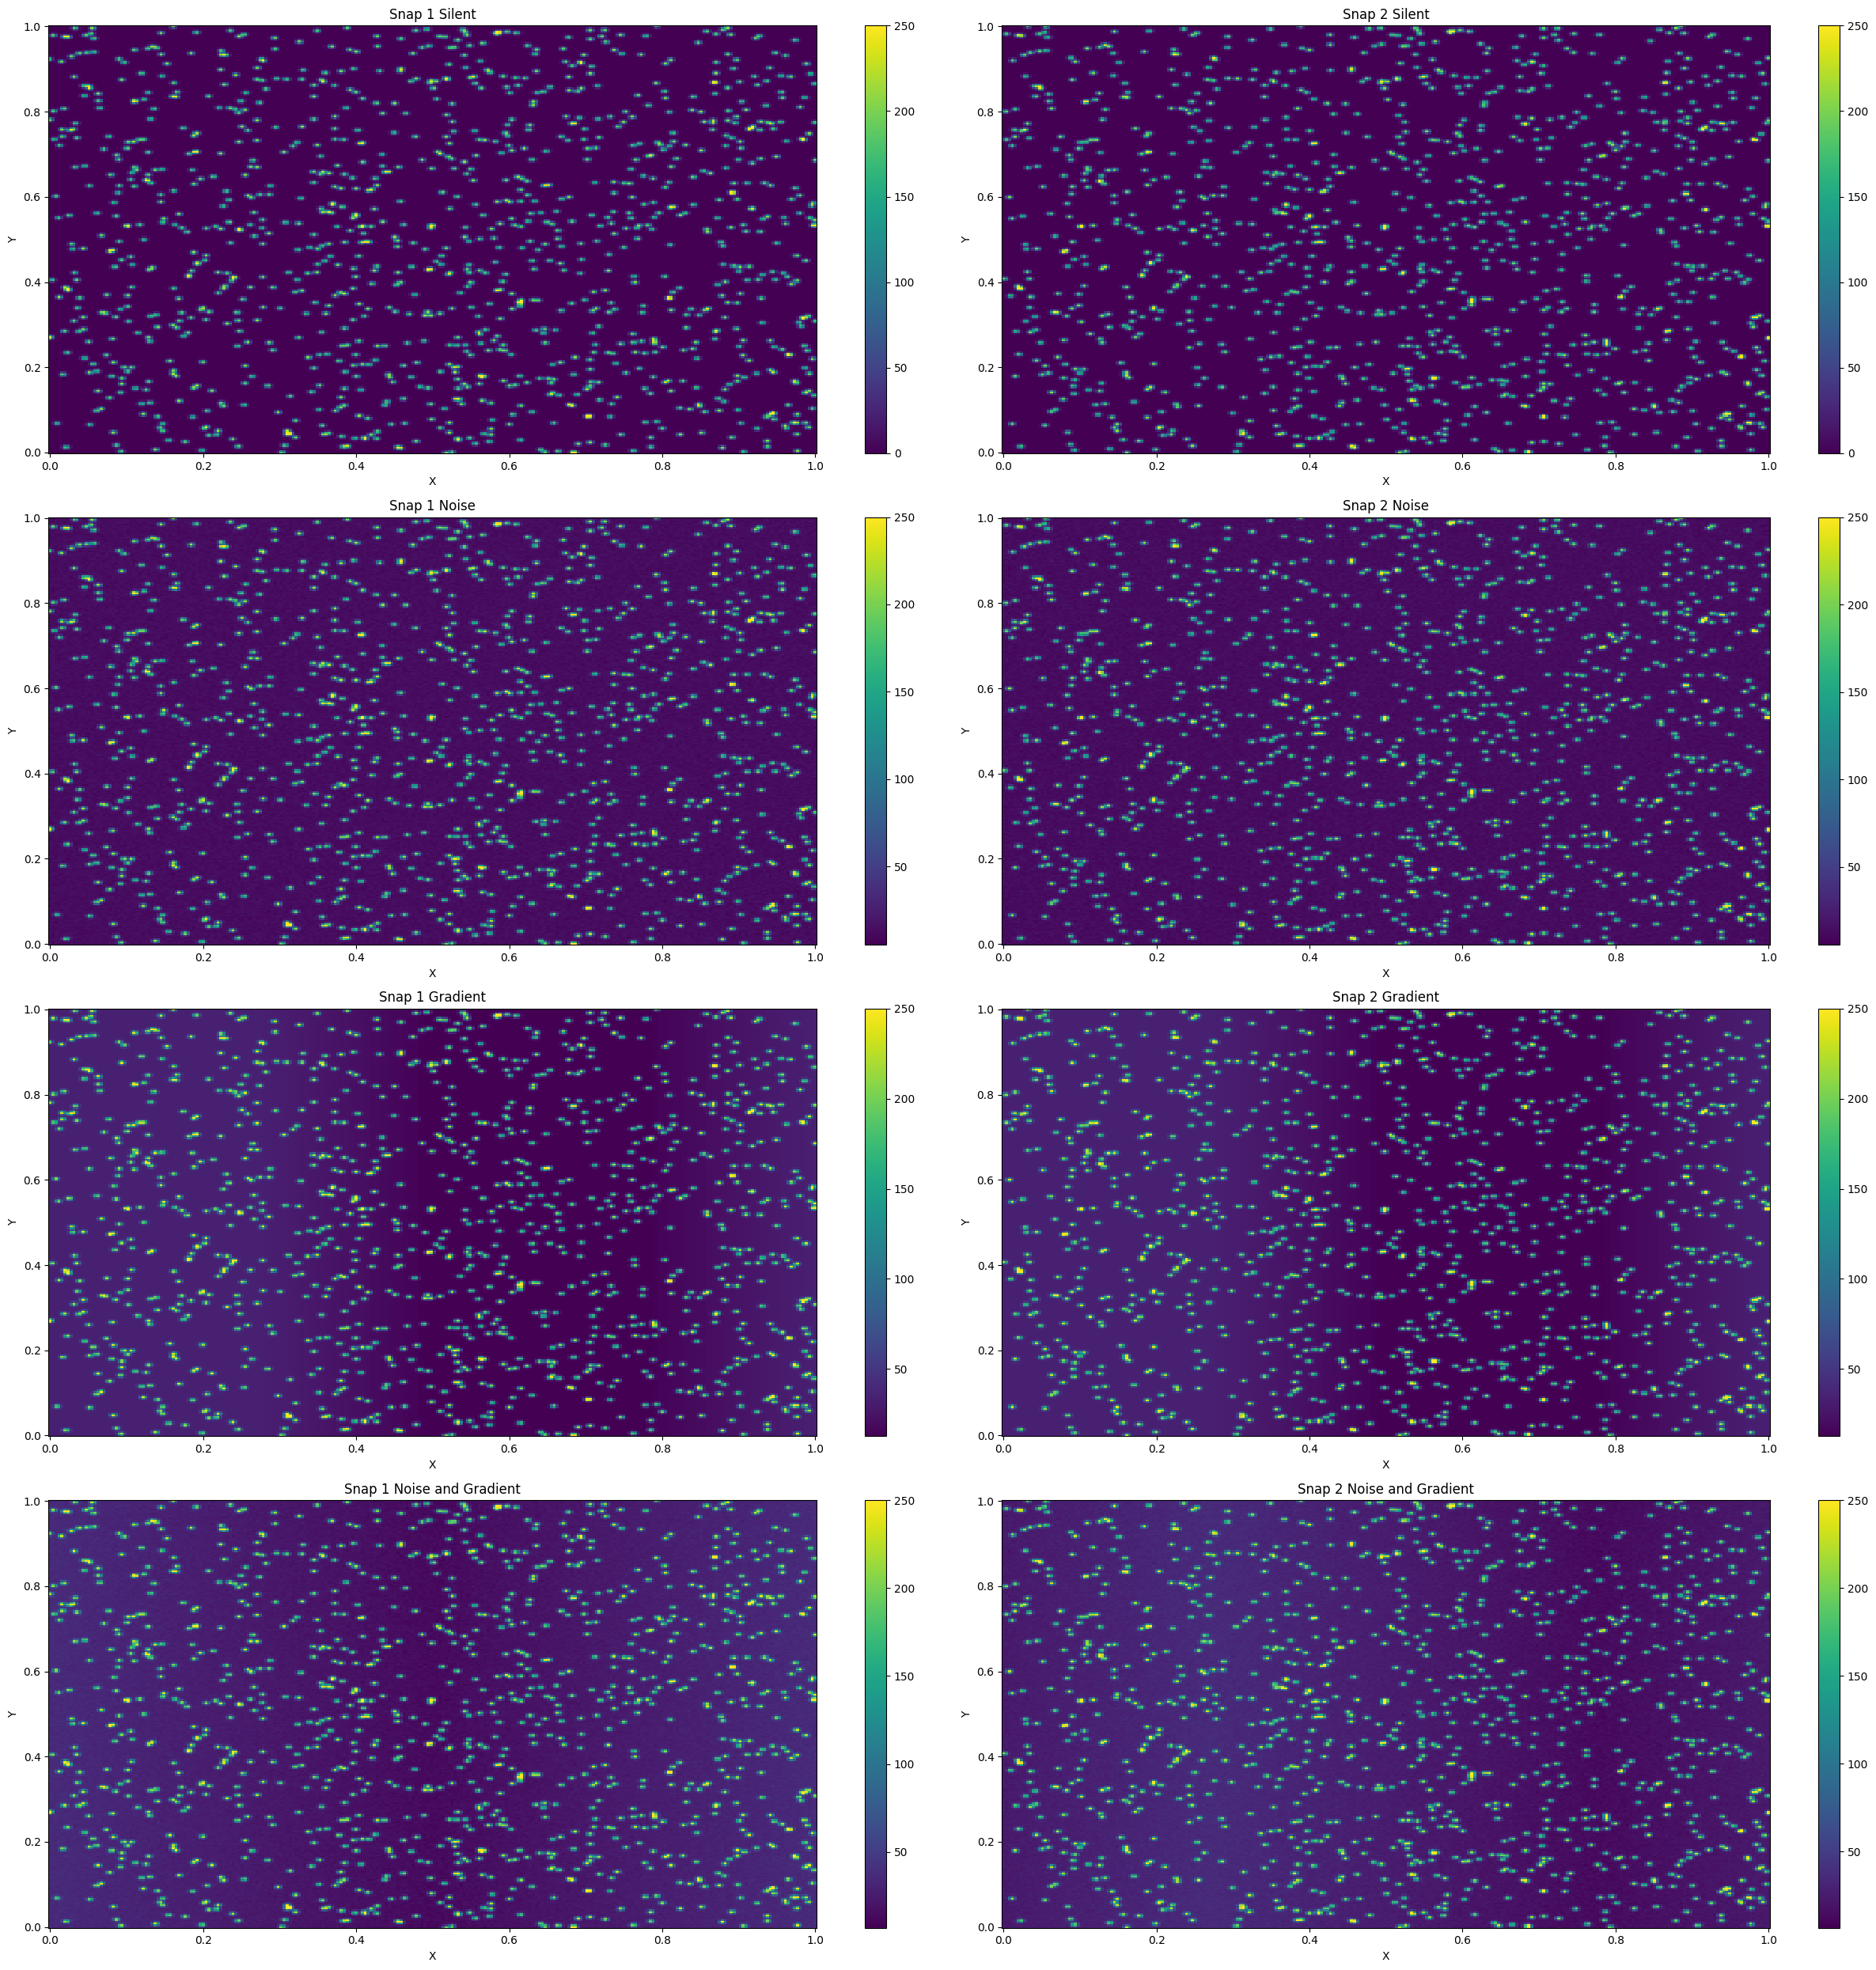

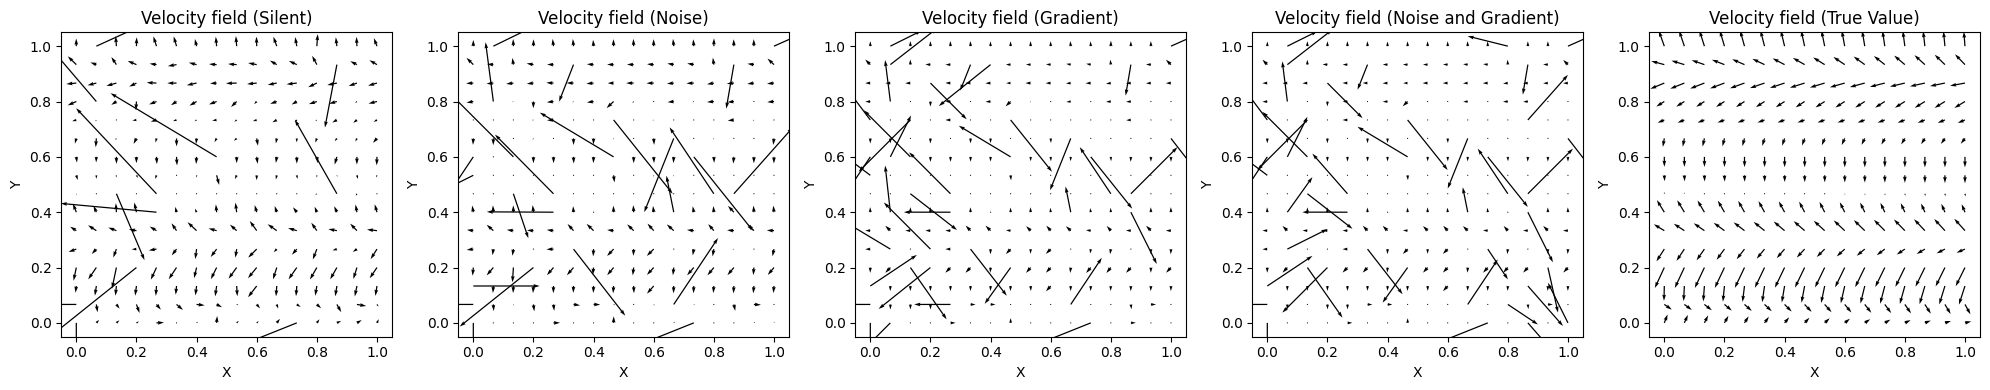

In [51]:
# particle_movement()
intensity_mean_graph();
all_PIV_velocity_field_plots();

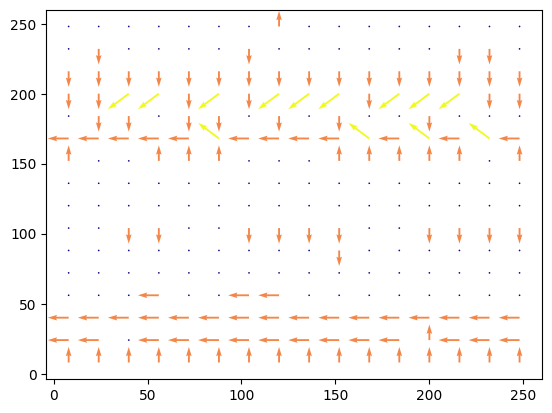

In [53]:
plt.quiver(xs,ys[::-1],dxs,dys,   norm_drs,cmap="plasma",angles="xy",scale_units="xy", scale= 0.09)